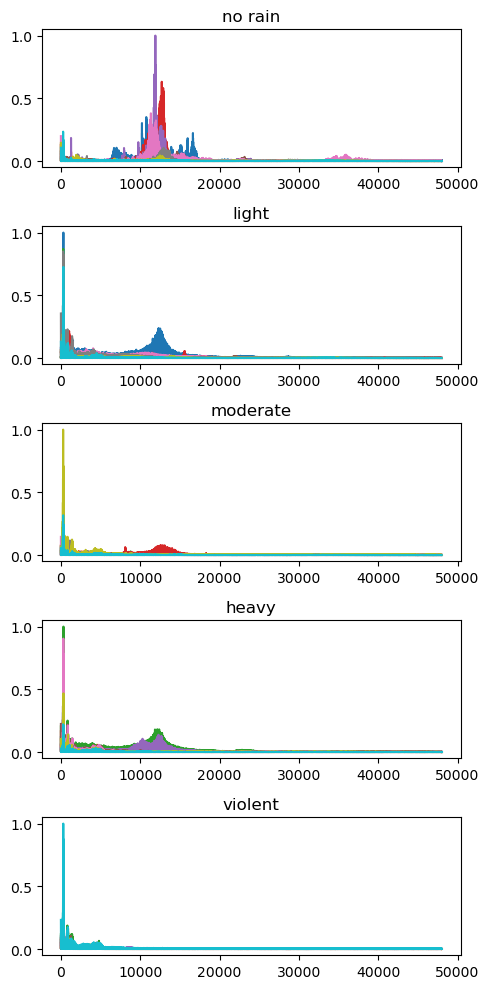

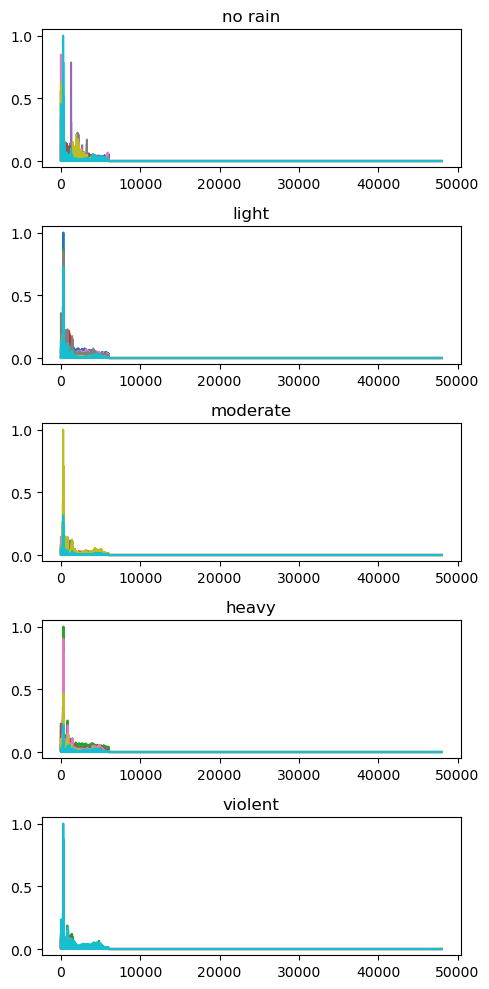

In [14]:
"""
conda install -c conda-forge google-auth-oauthlib google-auth-httplib2 pydrive


import librosa
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaDownload

auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
drive_service = build('drive', 'v3', credentials=creds)

query = "mimeType='audio/*'"
results = drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
files = results.get('files', [])

for file in files:
    request = drive_service.files().get_media(fileId=file['id'])
    fh = open(file['name'], 'wb')
    downloader = MediaDownload(request, fh)
    while not downloader.complete:
        downloader.next_chunk()
    fh.close()

    y, sr = librosa.load(file['name'])
    # Perform your audio processing here
"""



import os
import numpy as np
from scipy.fft import fft
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def low_pass_filter(data, sample_rate, cutoff_freq):
    """
    Apply a low-pass filter to the audio signal using FFT.

    Parameters:
    data (numpy.ndarray): The audio signal data.
    sample_rate (int): The sample rate of the audio signal.
    cutoff_freq (float): The cut-off frequency for the low-pass filter.

    Returns:
    numpy.ndarray: The filtered audio signal.
    """
    # Compute the FFT of the data
    data_fft = fft(data)
    
    # Frequency array
    freqs = np.fft.fftfreq(len(data), 1/sample_rate)
    
    # Create a mask for frequencies higher than the cutoff frequency
    mask = np.abs(freqs) > cutoff_freq
    
    # Apply the mask to the FFT data
    data_fft[mask] = 0
    
    # Compute the inverse FFT to get the filtered signal
    filtered_data = np.fft.ifft(data_fft)
    
    # Return the real part of the filtered signal
    return np.real(filtered_data)

def normalize_array(arr):
    """Normalize the values of a NumPy array to the range [0, 1]."""
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    
    # Avoid division by zero in case the array has all identical values
    if arr_min == arr_max:
        return np.zeros_like(arr)
    
    return (arr - arr_min) / (arr_max - arr_min)

def compute_spectra(folder_path, cutoff_freq=None):
    # List to store frequency spectra
    spectra = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            # Read the audio file
            sample_rate, data = wav.read(os.path.join(folder_path, filename))
            # print(f'Processing {filename} with sample rate {sample_rate} Hz')

            if cutoff_freq is not None:
                # Apply a low-pass filter to the audio signal
                data = low_pass_filter(data, sample_rate, cutoff_freq)

            # Compute the FFT of the audio signal
            spectrum = np.abs(fft(data))[:len(data)//2]

            # Append the spectrum to the list
            spectra.append(spectrum)

    # Convert the list of spectra to a numpy array
    spectra_array = normalize_array(np.array(spectra))
    
    return spectra_array

# List of subfolders in the current directory
folder_path = ['no rain', 'light', 'moderate', 'heavy', 'violent']

# Frequency values for x-axis
freq = np.linspace(0, 48000, len(spectra[0][0]))

# Normal frequency range
spectra = []

# Iterate over all subfolders
for folder in folder_path:
    # Compute the spectra for the audio files in the subfolder
    spectra_array = compute_spectra(folder)
    # Append the spectra array to the list
    spectra.append(spectra_array)

# Plotting each row of the numpy array in the spectra list
fig, axs = plt.subplots(len(spectra), 1, figsize=(5, 10))

for i, spectrum in enumerate(spectra):
    for row in spectrum:
        axs[i].plot(freq, row)
        axs[i].set_title(f'{folder_path[i]}')

plt.tight_layout()
plt.show()

# Low pass filter
spectra = []

# Iterate over all subfolders
for folder in folder_path:
    # Compute the spectra for the audio files in the subfolder
    spectra_array = compute_spectra(folder, 3000)
    # Append the spectra array to the list
    spectra.append(spectra_array)

# Plotting each row of the numpy array in the spectra list
fig, axs = plt.subplots(len(spectra), 1, figsize=(5, 10))

for i, spectrum in enumerate(spectra):
    for row in spectrum:
        axs[i].plot(freq, row)
        axs[i].set_title(f'{folder_path[i]}')

plt.tight_layout()
plt.show()